# Minimal DDIM (CIFAR-10) with SGD

In [1]:
# Imports
from pathlib import Path
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

# Import implementation
from implementations.base_implementation import (
    DiffusionSchedule, UNet, sample_loop, train_ddim)

# import numpy as np
# import random
# seed = 0
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

# # Deterministic operations (Optional but recommended for exact reproducibility)
# # Note: This might make training slower. If speed is priority, keep benchmark=True
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

print('torch:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device ->', device)

torch: 2.9.0+cu126
device -> cuda
torch: 2.9.0+cu126
device -> cuda


In [2]:
# CIFAR-10 data loaders
def get_dataloaders(batch_size=128, img_size=32, num_workers=4):
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),  # map to [-1,1]
    ])
    train_ds = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_ds = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    return train_loader, test_loader

train_loader, test_loader = get_dataloaders(batch_size=128, img_size=32, num_workers=2)

In [3]:
# Helper to show saved sample grid
from PIL import Image
def show_image(path, figsize=(6,6)):
    img = Image.open(path)
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis('off')
    plt.show()


In [5]:
# WARNING: Training DDIM on CIFAR-10 is moderately heavy. Reduce epochs or timesteps for quick tests.
timesteps = 1000  # use 1000 for standard DDIM training; reduce for inference
model = UNet(in_ch=3, base_ch=64, time_emb_dim=64)
schedule = DiffusionSchedule(timesteps=timesteps, device=device)
print(f'Model parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M')

# To run training WITH lambda max computation, uncomment the following line:
train_ddim(
    model, schedule, train_loader, device,
    epochs=100,
    lr=2e-4,
    save_dir='./runs_ddim', 
    ema_decay=0.995,
)

print('Notebook set up. To begin training, call train_ddim(...) as shown above.')

Model parameters: 8.22M
Compiling model...


Epoch 1/100: 100%|██████████| 391/391 [00:28<00:00, 13.55it/s, loss=0.0961, lr=0.00020]


End epoch 1, avg loss 0.1435


DDIM Sampling:   0%|          | 0/100 [00:00<?, ?it/s]/home/arthurdls/anaconda3/envs/eos-diffusion/lib/python3.12/site-packages/torch/backends/cuda/__init__.py:131: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return torch._C._get_cublas_allow_tf32()
/home/arthurdls/anaconda3/envs/eos-diffusion/lib/python3.12/site-packages/torch/_inductor/compile_fx.py:312: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_pre

Saved samples to runs_ddim/samples_epoch_1.png


Epoch 2/100: 100%|██████████| 391/391 [00:28<00:00, 13.63it/s, loss=0.0823, lr=0.00020]


End epoch 2, avg loss 0.0802


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 150.72it/s]


Saved samples to runs_ddim/samples_epoch_2.png


Epoch 3/100: 100%|██████████| 391/391 [00:28<00:00, 13.56it/s, loss=0.0763, lr=0.00020]


End epoch 3, avg loss 0.0725


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 150.93it/s]


Saved samples to runs_ddim/samples_epoch_3.png


Epoch 4/100: 100%|██████████| 391/391 [00:29<00:00, 13.38it/s, loss=0.0639, lr=0.00020]


End epoch 4, avg loss 0.0686


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 151.88it/s]


Saved samples to runs_ddim/samples_epoch_4.png


Epoch 5/100: 100%|██████████| 391/391 [00:29<00:00, 13.12it/s, loss=0.0611, lr=0.00020]


End epoch 5, avg loss 0.0664


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 151.89it/s]


Saved samples to runs_ddim/samples_epoch_5.png


Epoch 6/100: 100%|██████████| 391/391 [00:29<00:00, 13.20it/s, loss=0.0728, lr=0.00020]


End epoch 6, avg loss 0.0655


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 151.33it/s]


Saved samples to runs_ddim/samples_epoch_6.png


Epoch 7/100: 100%|██████████| 391/391 [00:29<00:00, 13.19it/s, loss=0.0589, lr=0.00020]


End epoch 7, avg loss 0.0640


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 147.79it/s]


Saved samples to runs_ddim/samples_epoch_7.png


Epoch 8/100: 100%|██████████| 391/391 [00:29<00:00, 13.14it/s, loss=0.0691, lr=0.00020]


End epoch 8, avg loss 0.0637


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 152.01it/s]


Saved samples to runs_ddim/samples_epoch_8.png


Epoch 9/100: 100%|██████████| 391/391 [00:29<00:00, 13.13it/s, loss=0.0704, lr=0.00020]


End epoch 9, avg loss 0.0623


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 152.36it/s]


Saved samples to runs_ddim/samples_epoch_9.png


Epoch 10/100: 100%|██████████| 391/391 [00:29<00:00, 13.10it/s, loss=0.0768, lr=0.00020]


End epoch 10, avg loss 0.0627


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 153.42it/s]


Saved samples to runs_ddim/samples_epoch_10.png


Epoch 11/100: 100%|██████████| 391/391 [00:29<00:00, 13.18it/s, loss=0.0577, lr=0.00019]


End epoch 11, avg loss 0.0613


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 153.32it/s]


Saved samples to runs_ddim/samples_epoch_11.png


Epoch 12/100: 100%|██████████| 391/391 [00:29<00:00, 13.13it/s, loss=0.0572, lr=0.00019]


End epoch 12, avg loss 0.0607


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 149.34it/s]


Saved samples to runs_ddim/samples_epoch_12.png


Epoch 13/100: 100%|██████████| 391/391 [00:29<00:00, 13.14it/s, loss=0.0504, lr=0.00019]


End epoch 13, avg loss 0.0614


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 154.65it/s]


Saved samples to runs_ddim/samples_epoch_13.png


Epoch 14/100: 100%|██████████| 391/391 [00:30<00:00, 12.98it/s, loss=0.0595, lr=0.00019]


End epoch 14, avg loss 0.0609


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 148.45it/s]


Saved samples to runs_ddim/samples_epoch_14.png


Epoch 15/100: 100%|██████████| 391/391 [00:29<00:00, 13.08it/s, loss=0.0556, lr=0.00019]


End epoch 15, avg loss 0.0605


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 149.77it/s]


Saved samples to runs_ddim/samples_epoch_15.png


Epoch 16/100: 100%|██████████| 391/391 [00:30<00:00, 13.02it/s, loss=0.0646, lr=0.00019]


End epoch 16, avg loss 0.0602


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 149.04it/s]


Saved samples to runs_ddim/samples_epoch_16.png


Epoch 17/100: 100%|██████████| 391/391 [00:30<00:00, 13.01it/s, loss=0.0561, lr=0.00019]


End epoch 17, avg loss 0.0606


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 150.47it/s]


Saved samples to runs_ddim/samples_epoch_17.png


Epoch 18/100: 100%|██████████| 391/391 [00:29<00:00, 13.06it/s, loss=0.0581, lr=0.00018]


End epoch 18, avg loss 0.0603


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 149.38it/s]


Saved samples to runs_ddim/samples_epoch_18.png


Epoch 19/100: 100%|██████████| 391/391 [00:30<00:00, 13.02it/s, loss=0.0488, lr=0.00018]


End epoch 19, avg loss 0.0604


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 148.39it/s]


Saved samples to runs_ddim/samples_epoch_19.png


Epoch 20/100: 100%|██████████| 391/391 [00:29<00:00, 13.06it/s, loss=0.0553, lr=0.00018]


End epoch 20, avg loss 0.0589


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 148.86it/s]


Saved samples to runs_ddim/samples_epoch_20.png


Epoch 21/100: 100%|██████████| 391/391 [00:29<00:00, 13.07it/s, loss=0.0513, lr=0.00018]


End epoch 21, avg loss 0.0594


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 150.25it/s]


Saved samples to runs_ddim/samples_epoch_21.png


Epoch 22/100: 100%|██████████| 391/391 [00:30<00:00, 12.90it/s, loss=0.0794, lr=0.00018]


End epoch 22, avg loss 0.0587


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 147.77it/s]


Saved samples to runs_ddim/samples_epoch_22.png


Epoch 23/100: 100%|██████████| 391/391 [00:30<00:00, 12.97it/s, loss=0.0544, lr=0.00018]


End epoch 23, avg loss 0.0586


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 150.77it/s]


Saved samples to runs_ddim/samples_epoch_23.png


Epoch 24/100: 100%|██████████| 391/391 [00:30<00:00, 12.98it/s, loss=0.0504, lr=0.00017]


End epoch 24, avg loss 0.0585


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 147.08it/s]


Saved samples to runs_ddim/samples_epoch_24.png


Epoch 25/100: 100%|██████████| 391/391 [00:29<00:00, 13.09it/s, loss=0.0740, lr=0.00017]


End epoch 25, avg loss 0.0580


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 161.82it/s]


Saved samples to runs_ddim/samples_epoch_25.png


Epoch 26/100: 100%|██████████| 391/391 [00:29<00:00, 13.35it/s, loss=0.0616, lr=0.00017]


End epoch 26, avg loss 0.0589


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 160.42it/s]


Saved samples to runs_ddim/samples_epoch_26.png


Epoch 27/100: 100%|██████████| 391/391 [00:29<00:00, 13.47it/s, loss=0.0591, lr=0.00017]


End epoch 27, avg loss 0.0583


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 156.96it/s]


Saved samples to runs_ddim/samples_epoch_27.png


Epoch 28/100: 100%|██████████| 391/391 [00:28<00:00, 13.49it/s, loss=0.0590, lr=0.00016]


End epoch 28, avg loss 0.0583


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 157.45it/s]


Saved samples to runs_ddim/samples_epoch_28.png


Epoch 29/100: 100%|██████████| 391/391 [00:28<00:00, 13.53it/s, loss=0.0604, lr=0.00016]


End epoch 29, avg loss 0.0584


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 158.17it/s]


Saved samples to runs_ddim/samples_epoch_29.png


Epoch 30/100: 100%|██████████| 391/391 [00:28<00:00, 13.54it/s, loss=0.0484, lr=0.00016]


End epoch 30, avg loss 0.0582


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 162.91it/s]


Saved samples to runs_ddim/samples_epoch_30.png


Epoch 31/100: 100%|██████████| 391/391 [00:29<00:00, 13.44it/s, loss=0.0544, lr=0.00016]


End epoch 31, avg loss 0.0582


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 147.17it/s]


Saved samples to runs_ddim/samples_epoch_31.png


Epoch 32/100: 100%|██████████| 391/391 [00:29<00:00, 13.15it/s, loss=0.0596, lr=0.00015]


End epoch 32, avg loss 0.0580


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 151.89it/s]


Saved samples to runs_ddim/samples_epoch_32.png


Epoch 33/100: 100%|██████████| 391/391 [00:29<00:00, 13.35it/s, loss=0.0563, lr=0.00015]


End epoch 33, avg loss 0.0582


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 157.89it/s]


Saved samples to runs_ddim/samples_epoch_33.png


Epoch 34/100: 100%|██████████| 391/391 [00:29<00:00, 13.08it/s, loss=0.0712, lr=0.00015]


End epoch 34, avg loss 0.0574


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 149.81it/s]


Saved samples to runs_ddim/samples_epoch_34.png


Epoch 35/100: 100%|██████████| 391/391 [00:30<00:00, 12.79it/s, loss=0.0530, lr=0.00015]


End epoch 35, avg loss 0.0577


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 143.96it/s]


Saved samples to runs_ddim/samples_epoch_35.png


Epoch 36/100: 100%|██████████| 391/391 [00:30<00:00, 12.69it/s, loss=0.0630, lr=0.00014]


End epoch 36, avg loss 0.0583


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 159.33it/s]


Saved samples to runs_ddim/samples_epoch_36.png


Epoch 37/100: 100%|██████████| 391/391 [00:29<00:00, 13.16it/s, loss=0.0569, lr=0.00014]


End epoch 37, avg loss 0.0571


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 157.35it/s]


Saved samples to runs_ddim/samples_epoch_37.png


Epoch 38/100: 100%|██████████| 391/391 [00:29<00:00, 13.29it/s, loss=0.0617, lr=0.00014]


End epoch 38, avg loss 0.0576


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 148.02it/s]


Saved samples to runs_ddim/samples_epoch_38.png


Epoch 39/100: 100%|██████████| 391/391 [00:30<00:00, 12.89it/s, loss=0.0575, lr=0.00013]


End epoch 39, avg loss 0.0578


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 145.76it/s]


Saved samples to runs_ddim/samples_epoch_39.png


Epoch 40/100: 100%|██████████| 391/391 [00:30<00:00, 12.96it/s, loss=0.0651, lr=0.00013]


End epoch 40, avg loss 0.0571


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 147.43it/s]


Saved samples to runs_ddim/samples_epoch_40.png


Epoch 41/100: 100%|██████████| 391/391 [00:30<00:00, 12.99it/s, loss=0.0554, lr=0.00013]


End epoch 41, avg loss 0.0571


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 147.79it/s]


Saved samples to runs_ddim/samples_epoch_41.png


Epoch 42/100: 100%|██████████| 391/391 [00:30<00:00, 12.96it/s, loss=0.0566, lr=0.00013]


End epoch 42, avg loss 0.0573


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 149.72it/s]


Saved samples to runs_ddim/samples_epoch_42.png


Epoch 43/100: 100%|██████████| 391/391 [00:29<00:00, 13.16it/s, loss=0.0670, lr=0.00012]


End epoch 43, avg loss 0.0573


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 155.58it/s]


Saved samples to runs_ddim/samples_epoch_43.png


Epoch 44/100: 100%|██████████| 391/391 [00:29<00:00, 13.31it/s, loss=0.0577, lr=0.00012]


End epoch 44, avg loss 0.0577


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 152.76it/s]


Saved samples to runs_ddim/samples_epoch_44.png


Epoch 45/100: 100%|██████████| 391/391 [00:29<00:00, 13.39it/s, loss=0.0486, lr=0.00012]


End epoch 45, avg loss 0.0571


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 160.48it/s]


Saved samples to runs_ddim/samples_epoch_45.png


Epoch 46/100: 100%|██████████| 391/391 [00:28<00:00, 13.51it/s, loss=0.0578, lr=0.00011]


End epoch 46, avg loss 0.0575


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 164.26it/s]


Saved samples to runs_ddim/samples_epoch_46.png


Epoch 47/100: 100%|██████████| 391/391 [00:28<00:00, 13.56it/s, loss=0.0606, lr=0.00011]


End epoch 47, avg loss 0.0572


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 160.66it/s]


Saved samples to runs_ddim/samples_epoch_47.png


Epoch 48/100: 100%|██████████| 391/391 [00:28<00:00, 13.61it/s, loss=0.0510, lr=0.00011]


End epoch 48, avg loss 0.0567


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 160.91it/s]


Saved samples to runs_ddim/samples_epoch_48.png


Epoch 49/100: 100%|██████████| 391/391 [00:28<00:00, 13.59it/s, loss=0.0494, lr=0.00010]


End epoch 49, avg loss 0.0570


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 155.60it/s]


Saved samples to runs_ddim/samples_epoch_49.png


Epoch 50/100: 100%|██████████| 391/391 [00:28<00:00, 13.62it/s, loss=0.0511, lr=0.00010]


End epoch 50, avg loss 0.0570


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 165.39it/s]


Saved samples to runs_ddim/samples_epoch_50.png


Epoch 51/100: 100%|██████████| 391/391 [00:28<00:00, 13.62it/s, loss=0.0499, lr=0.00010]


End epoch 51, avg loss 0.0565


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 163.67it/s]


Saved samples to runs_ddim/samples_epoch_51.png


Epoch 52/100: 100%|██████████| 391/391 [00:28<00:00, 13.59it/s, loss=0.0592, lr=0.00009]


End epoch 52, avg loss 0.0570


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 160.79it/s]


Saved samples to runs_ddim/samples_epoch_52.png


Epoch 53/100: 100%|██████████| 391/391 [00:28<00:00, 13.62it/s, loss=0.0500, lr=0.00009]


End epoch 53, avg loss 0.0571


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 160.15it/s]


Saved samples to runs_ddim/samples_epoch_53.png


Epoch 54/100: 100%|██████████| 391/391 [00:28<00:00, 13.63it/s, loss=0.0510, lr=0.00009]


End epoch 54, avg loss 0.0572


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 160.33it/s]


Saved samples to runs_ddim/samples_epoch_54.png


Epoch 55/100: 100%|██████████| 391/391 [00:28<00:00, 13.57it/s, loss=0.0523, lr=0.00008]


End epoch 55, avg loss 0.0566


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 161.85it/s]


Saved samples to runs_ddim/samples_epoch_55.png


Epoch 56/100: 100%|██████████| 391/391 [00:28<00:00, 13.61it/s, loss=0.0455, lr=0.00008]


End epoch 56, avg loss 0.0566


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 160.87it/s]


Saved samples to runs_ddim/samples_epoch_56.png


Epoch 57/100: 100%|██████████| 391/391 [00:28<00:00, 13.62it/s, loss=0.0506, lr=0.00008]


End epoch 57, avg loss 0.0570


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 161.57it/s]


Saved samples to runs_ddim/samples_epoch_57.png


Epoch 58/100: 100%|██████████| 391/391 [00:28<00:00, 13.60it/s, loss=0.0672, lr=0.00008]


End epoch 58, avg loss 0.0564


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 155.68it/s]


Saved samples to runs_ddim/samples_epoch_58.png


Epoch 59/100: 100%|██████████| 391/391 [00:29<00:00, 13.35it/s, loss=0.0505, lr=0.00007]


End epoch 59, avg loss 0.0565


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 162.60it/s]


Saved samples to runs_ddim/samples_epoch_59.png


Epoch 60/100: 100%|██████████| 391/391 [00:28<00:00, 13.64it/s, loss=0.0476, lr=0.00007]


End epoch 60, avg loss 0.0563


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 160.02it/s]


Saved samples to runs_ddim/samples_epoch_60.png


Epoch 61/100: 100%|██████████| 391/391 [00:28<00:00, 13.62it/s, loss=0.0575, lr=0.00007]


End epoch 61, avg loss 0.0562


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 161.16it/s]


Saved samples to runs_ddim/samples_epoch_61.png


Epoch 62/100: 100%|██████████| 391/391 [00:28<00:00, 13.60it/s, loss=0.0562, lr=0.00006]


End epoch 62, avg loss 0.0565


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 159.15it/s]


Saved samples to runs_ddim/samples_epoch_62.png


Epoch 63/100: 100%|██████████| 391/391 [00:28<00:00, 13.61it/s, loss=0.0691, lr=0.00006]


End epoch 63, avg loss 0.0565


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 160.21it/s]


Saved samples to runs_ddim/samples_epoch_63.png


Epoch 64/100: 100%|██████████| 391/391 [00:28<00:00, 13.62it/s, loss=0.0536, lr=0.00006]


End epoch 64, avg loss 0.0565


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 164.15it/s]


Saved samples to runs_ddim/samples_epoch_64.png


Epoch 65/100: 100%|██████████| 391/391 [00:28<00:00, 13.63it/s, loss=0.0640, lr=0.00005]


End epoch 65, avg loss 0.0560


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 160.97it/s]


Saved samples to runs_ddim/samples_epoch_65.png


Epoch 66/100: 100%|██████████| 391/391 [00:28<00:00, 13.63it/s, loss=0.0538, lr=0.00005]


End epoch 66, avg loss 0.0559


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 156.92it/s]


Saved samples to runs_ddim/samples_epoch_66.png


Epoch 67/100: 100%|██████████| 391/391 [00:28<00:00, 13.62it/s, loss=0.0519, lr=0.00005]


End epoch 67, avg loss 0.0562


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 160.41it/s]


Saved samples to runs_ddim/samples_epoch_67.png


Epoch 68/100: 100%|██████████| 391/391 [00:33<00:00, 11.77it/s, loss=0.0439, lr=0.00005]


End epoch 68, avg loss 0.0560


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 163.68it/s]


Saved samples to runs_ddim/samples_epoch_68.png


Epoch 69/100: 100%|██████████| 391/391 [00:28<00:00, 13.63it/s, loss=0.0502, lr=0.00004]


End epoch 69, avg loss 0.0561


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 161.40it/s]


Saved samples to runs_ddim/samples_epoch_69.png


Epoch 70/100: 100%|██████████| 391/391 [00:28<00:00, 13.59it/s, loss=0.0496, lr=0.00004]


End epoch 70, avg loss 0.0563


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 164.03it/s]


Saved samples to runs_ddim/samples_epoch_70.png


Epoch 71/100: 100%|██████████| 391/391 [00:28<00:00, 13.58it/s, loss=0.0509, lr=0.00004]


End epoch 71, avg loss 0.0566


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 162.77it/s]


Saved samples to runs_ddim/samples_epoch_71.png


Epoch 72/100: 100%|██████████| 391/391 [00:28<00:00, 13.62it/s, loss=0.0594, lr=0.00004]


End epoch 72, avg loss 0.0558


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 161.63it/s]


Saved samples to runs_ddim/samples_epoch_72.png


Epoch 73/100: 100%|██████████| 391/391 [00:28<00:00, 13.61it/s, loss=0.0687, lr=0.00003]


End epoch 73, avg loss 0.0558


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 162.20it/s]


Saved samples to runs_ddim/samples_epoch_73.png


Epoch 74/100: 100%|██████████| 391/391 [00:28<00:00, 13.59it/s, loss=0.0587, lr=0.00003]


End epoch 74, avg loss 0.0567


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 161.83it/s]


Saved samples to runs_ddim/samples_epoch_74.png


Epoch 75/100: 100%|██████████| 391/391 [00:28<00:00, 13.58it/s, loss=0.0580, lr=0.00003]


End epoch 75, avg loss 0.0568


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 165.13it/s]


Saved samples to runs_ddim/samples_epoch_75.png


Epoch 76/100: 100%|██████████| 391/391 [00:28<00:00, 13.62it/s, loss=0.0558, lr=0.00003]


End epoch 76, avg loss 0.0553


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 162.59it/s]


Saved samples to runs_ddim/samples_epoch_76.png


Epoch 77/100: 100%|██████████| 391/391 [00:28<00:00, 13.61it/s, loss=0.0583, lr=0.00003]


End epoch 77, avg loss 0.0559


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 159.79it/s]


Saved samples to runs_ddim/samples_epoch_77.png


Epoch 78/100: 100%|██████████| 391/391 [00:28<00:00, 13.59it/s, loss=0.0562, lr=0.00002]


End epoch 78, avg loss 0.0563


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 161.35it/s]


Saved samples to runs_ddim/samples_epoch_78.png


Epoch 79/100: 100%|██████████| 391/391 [00:28<00:00, 13.58it/s, loss=0.0652, lr=0.00002]


End epoch 79, avg loss 0.0562


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 162.80it/s]


Saved samples to runs_ddim/samples_epoch_79.png


Epoch 80/100: 100%|██████████| 391/391 [00:28<00:00, 13.60it/s, loss=0.0528, lr=0.00002]


End epoch 80, avg loss 0.0561


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 163.02it/s]


Saved samples to runs_ddim/samples_epoch_80.png


Epoch 81/100: 100%|██████████| 391/391 [00:28<00:00, 13.58it/s, loss=0.0565, lr=0.00002]


End epoch 81, avg loss 0.0556


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 161.92it/s]


Saved samples to runs_ddim/samples_epoch_81.png


Epoch 82/100: 100%|██████████| 391/391 [00:28<00:00, 13.58it/s, loss=0.0596, lr=0.00002]


End epoch 82, avg loss 0.0556


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 163.34it/s]


Saved samples to runs_ddim/samples_epoch_82.png


Epoch 83/100: 100%|██████████| 391/391 [00:28<00:00, 13.59it/s, loss=0.0497, lr=0.00001]


End epoch 83, avg loss 0.0554


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 163.06it/s]


Saved samples to runs_ddim/samples_epoch_83.png


Epoch 84/100: 100%|██████████| 391/391 [00:28<00:00, 13.59it/s, loss=0.0549, lr=0.00001]


End epoch 84, avg loss 0.0557


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 163.63it/s]


Saved samples to runs_ddim/samples_epoch_84.png


Epoch 85/100: 100%|██████████| 391/391 [00:28<00:00, 13.59it/s, loss=0.0590, lr=0.00001]


End epoch 85, avg loss 0.0563


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 164.80it/s]


Saved samples to runs_ddim/samples_epoch_85.png


Epoch 86/100: 100%|██████████| 391/391 [00:29<00:00, 13.47it/s, loss=0.0663, lr=0.00001]


End epoch 86, avg loss 0.0554


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 159.24it/s]


Saved samples to runs_ddim/samples_epoch_86.png


Epoch 87/100: 100%|██████████| 391/391 [00:29<00:00, 13.46it/s, loss=0.0541, lr=0.00001]


End epoch 87, avg loss 0.0557


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 158.55it/s]


Saved samples to runs_ddim/samples_epoch_87.png


Epoch 88/100: 100%|██████████| 391/391 [00:29<00:00, 13.27it/s, loss=0.0646, lr=0.00001]


End epoch 88, avg loss 0.0562


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 147.19it/s]


Saved samples to runs_ddim/samples_epoch_88.png


Epoch 89/100: 100%|██████████| 391/391 [00:29<00:00, 13.06it/s, loss=0.0518, lr=0.00001]


End epoch 89, avg loss 0.0560


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 147.95it/s]


Saved samples to runs_ddim/samples_epoch_89.png


Epoch 90/100: 100%|██████████| 391/391 [00:30<00:00, 13.02it/s, loss=0.0591, lr=0.00001]


End epoch 90, avg loss 0.0559


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 157.34it/s]


Saved samples to runs_ddim/samples_epoch_90.png


Epoch 91/100: 100%|██████████| 391/391 [00:29<00:00, 13.33it/s, loss=0.0586, lr=0.00000]


End epoch 91, avg loss 0.0564


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 161.69it/s]


Saved samples to runs_ddim/samples_epoch_91.png


Epoch 92/100: 100%|██████████| 391/391 [00:28<00:00, 13.56it/s, loss=0.0540, lr=0.00000]


End epoch 92, avg loss 0.0556


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 162.05it/s]


Saved samples to runs_ddim/samples_epoch_92.png


Epoch 93/100: 100%|██████████| 391/391 [00:28<00:00, 13.60it/s, loss=0.0585, lr=0.00000]


End epoch 93, avg loss 0.0557


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 164.49it/s]


Saved samples to runs_ddim/samples_epoch_93.png


Epoch 94/100: 100%|██████████| 391/391 [00:28<00:00, 13.57it/s, loss=0.0444, lr=0.00000]


End epoch 94, avg loss 0.0559


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 163.67it/s]


Saved samples to runs_ddim/samples_epoch_94.png


Epoch 95/100: 100%|██████████| 391/391 [00:29<00:00, 13.47it/s, loss=0.0680, lr=0.00000]


End epoch 95, avg loss 0.0555


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 153.70it/s]


Saved samples to runs_ddim/samples_epoch_95.png


Epoch 96/100: 100%|██████████| 391/391 [00:28<00:00, 13.56it/s, loss=0.0545, lr=0.00000]


End epoch 96, avg loss 0.0561


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 153.87it/s]


Saved samples to runs_ddim/samples_epoch_96.png


Epoch 97/100: 100%|██████████| 391/391 [00:29<00:00, 13.25it/s, loss=0.0517, lr=0.00000]


End epoch 97, avg loss 0.0558


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 145.36it/s]


Saved samples to runs_ddim/samples_epoch_97.png


Epoch 98/100: 100%|██████████| 391/391 [00:30<00:00, 12.93it/s, loss=0.0606, lr=0.00000]


End epoch 98, avg loss 0.0559


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 148.28it/s]


Saved samples to runs_ddim/samples_epoch_98.png


Epoch 99/100: 100%|██████████| 391/391 [00:30<00:00, 12.79it/s, loss=0.0530, lr=0.00000]


End epoch 99, avg loss 0.0556


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 146.52it/s]


Saved samples to runs_ddim/samples_epoch_99.png


Epoch 100/100: 100%|██████████| 391/391 [00:30<00:00, 13.03it/s, loss=0.0614, lr=0.00000]


End epoch 100, avg loss 0.0567


DDIM Sampling: 100%|██████████| 100/100 [00:00<00:00, 156.87it/s]


Saved samples to runs_ddim/samples_epoch_100.png
Notebook set up. To begin training, call train_ddim(...) as shown above.


DDIM Sampling: 100%|██████████| 50/50 [00:00<00:00, 66.76it/s]


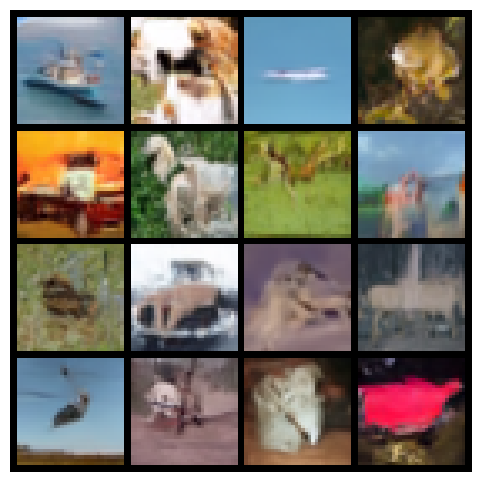

In [8]:
# Load a checkpoint and generate samples (example)
ckpt_path = './runs_ddim/checkpoint_epoch_100.pt'  # adjust to your path
if Path(ckpt_path).exists():
    ckpt = torch.load(ckpt_path, map_location=device)
    state_dict = ckpt['model_state']

    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('_orig_mod.'):
            new_state_dict[k.replace('_orig_mod.', '')] = v
        else:
            new_state_dict[k] = v

    model.load_state_dict(new_state_dict)
    model.to(device).eval()
    samples = sample_loop(model, schedule, (16,3,32,32), device=device)
    grid = (samples.clamp(-1,1) + 1) / 2.0
    utils.save_image(grid, 'sample_from_ckpt.png', nrow=4)
    show_image('sample_from_ckpt.png')
else:
    print('No checkpoint found at', ckpt_path)


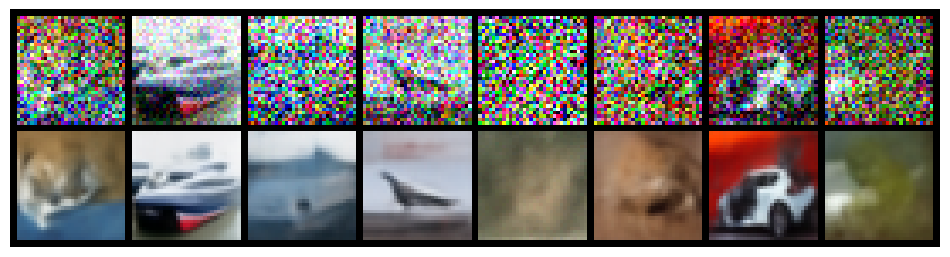

In [9]:
# Short diagnostic: take a test batch, add noise at random t, and visualize noisy vs. denoised (single-step prediction)
loader = test_loader
x, _ = next(iter(loader))
x = x[:8].to(device)
t = torch.randint(0, schedule.timesteps, (x.shape[0],), device=device)
noise = torch.randn_like(x)
x_noisy = schedule.q_sample(x, t, noise=noise)
with torch.no_grad():
    pred_noise = model(x_noisy, t)
    x0_pred = (x_noisy - schedule.sqrt_one_minus_alphas_cumprod[t].view(-1,1,1,1) * pred_noise) / schedule.sqrt_alphas_cumprod[t].view(-1,1,1,1)
    x0_pred = x0_pred.clamp(-1,1)
# show noisy and denoised pairs
pairs = torch.cat([x_noisy[:8], x0_pred[:8]], dim=0)
grid = (pairs + 1)/2.0
utils.save_image(grid, 'diagnostic_pairs.png', nrow=8)
show_image('diagnostic_pairs.png', figsize=(12,4))
